# Assignment-3 (NEURAL NETWORKS)


## Section 1: Data Loading & Visualization


Fetching the MNIST dataset (may take a moment the first time)...
Loaded data shapes: Images (70000, 784), Labels (70000,)
Displaying the first 5 images...


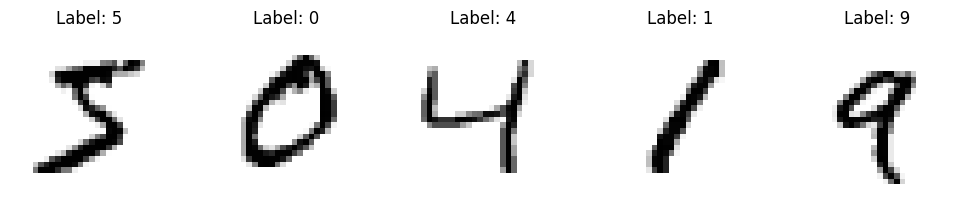

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import sys

def display_mnist_images_sharp(pixel_data, corresponding_labels):
    """
    Reshapes and displays images from a flat (N, 784) numpy array,
    including their corresponding labels as titles, using sharp interpolation.

    Args:
        pixel_data (np.ndarray): A numpy array of shape (N, 784).
        corresponding_labels (np.ndarray or list): An array/list of labels for the images.
    """
    num_images = pixel_data.shape[0]

    # Reshape the data from (N, 784) to (N, 28, 28)
    image_data = pixel_data.reshape(num_images, 28, 28)

    # Plot the images
    plt.figure(figsize=(10, 2))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Use interpolation='none' for sharp, blocky pixels
        plt.imshow(image_data[i], cmap='gray_r', interpolation='none')
        # Display the actual label as the plot title
        plt.title(f'Label: {corresponding_labels[i]}')
        plt.axis('off') # Hide axis ticks

    plt.tight_layout()
    plt.show()

# --- Main script execution ---

print("Fetching the MNIST dataset (may take a moment the first time)...")

try:
    # Fetch the MNIST dataset using scikit-learn
    mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

    # X contains the image data (pixel values), y contains the labels (0-9)
    X, y = mnist.data, mnist.target

    # Convert labels to integer type if they are strings (fetch_openml can return strings)
    y = y.astype(int)

    # Select the first 5 images and labels for demonstration
    num_samples_to_show = 5
    images_to_display = X[:num_samples_to_show]
    labels_to_display = y[:num_samples_to_show]

    print(f"Loaded data shapes: Images {X.shape}, Labels {y.shape}")
    print(f"Displaying the first {num_samples_to_show} images...")

    # Display the images using the defined function
    display_mnist_images_sharp(images_to_display, labels_to_display)

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("Please ensure you have an active internet connection to download the dataset.")
    print("If issues persist, try using the TensorFlow or PyTorch loading methods provided in the previous answers.")
    sys.exit(1)


## Section 2: Data Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# --- Normalization ---
# Pixel values in MNIST range from 0–255, so we scale them to 0–1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(f"Before normalization: min={X.min()}, max={X.max()}")
print(f"After normalization: min={X_scaled.min()}, max={X_scaled.max()}")

# --- One-hot encoding for labels (0–9) ---
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

print("\nExample:")
print("Original labels:", y[:5])
print("One-hot encoded labels:\n", y_encoded[:5])
print(X.shape)

Before normalization: min=0, max=255
After normalization: min=0.0, max=1.0

Example:
Original labels: [5 0 4 1 9]
One-hot encoded labels:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(70000, 784)


## Section 3: Splitting data into training, validation, and test sets

In [ ]:
from sklearn.model_selection import train_test_split

# Split into 60,000 (train + val) and 10,000 (test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y_encoded, test_size=10000, random_state=42
)

# From the 60,000 training set, take 10% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

# Display dataset shapes
print("✅ Dataset split summary:")
print(f"Training set:     {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set:   {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set:         {X_test.shape}, Labels: {y_test.shape}")


✅ Dataset split summary:
Training set:     (54000, 784), Labels: (54000, 10)
Validation set:   (6000, 784), Labels: (6000, 10)
Test set:         (10000, 784), Labels: (10000, 10)


## ## Section 4: Neural Network Architecture & Parameter Initialization

In [ ]:
# --- Neural Network Initialization ---

# Define architecture sizes
input_size = 784     # 28x28 pixels
hidden_size = 128    # You can tune this later
output_size = 10     # Digits 0–9

# Weight initialization (small random numbers)
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.01  # (784, 128)
b1 = np.zeros((1, hidden_size))                       # (1, 128)
W2 = np.random.randn(hidden_size, output_size) * 0.01 # (128, 10)
b2 = np.zeros((1, output_size))                       # (1, 10)

# Display initialized shapes for verification
print("✅ Parameter shapes:")
print("W1:", W1.shape, " b1:", b1.shape)
print("W2:", W2.shape, " b2:", b2.shape)


✅ Parameter shapes:
W1: (784, 128)  b1: (1, 128)
W2: (128, 10)  b2: (1, 10)


## Section 5: Forward Propagation

In [ ]:
# --- Forward Propagation Functions ---

def relu(Z):
    """Applies ReLU activation element-wise."""
    return np.maximum(0, Z)

def softmax(Z):
    """Computes the softmax activation for output layer."""
    exp_values = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # for numerical stability
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

def forward_propagation(X, W1, b1, W2, b2):
    """
    Performs a forward pass through the network.
    Returns intermediate values needed for backpropagation.
    """
    # Layer 1 (Input → Hidden)
    Z1 = np.dot(X, W1) + b1        # Linear combination
    A1 = relu(Z1)                  # ReLU activation

    # Layer 2 (Hidden → Output)
    Z2 = np.dot(A1, W2) + b2       # Linear combination
    A2 = softmax(Z2)               # Softmax activation (output probabilities)

    return Z1, A1, Z2, A2


In [ ]:
# Run a quick forward pass on 1 batch (e.g., first 5 samples)
Z1, A1, Z2, A2 = forward_propagation(X_train[:5], W1, b1, W2, b2)

print("Z1:", Z1.shape)
print("A1:", A1.shape)
print("Z2:", Z2.shape)
print("A2:", A2.shape)
print("Sum of A2 rows (should be ~1):", np.sum(A2, axis=1))


Z1: (5, 128)
A1: (5, 128)
Z2: (5, 10)
A2: (5, 10)
Sum of A2 rows (should be ~1): [1. 1. 1. 1. 1.]


## Section 6: Cross-Entropy Loss Computation

In [ ]:
def compute_loss(y_true, y_pred):
    """
    Computes the categorical cross-entropy loss.

    Args:
        y_true (np.ndarray): One-hot encoded true labels (N, 10)
        y_pred (np.ndarray): Predicted probabilities from softmax (N, 10)

    Returns:
        float: Average loss over the batch
    """
    # Add epsilon to avoid log(0)
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)

    # Compute cross-entropy
    loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    return loss


In [ ]:
# Forward pass on a small batch
_, _, _, A2 = forward_propagation(X_train[:5], W1, b1, W2, b2)
loss_val = compute_loss(y_train[:5], A2)

print("Sample batch loss:", loss_val)


Sample batch loss: 2.307173168684681


## Section 7: Backpropagation (Gradient Computation)

In [ ]:
def relu_derivative(Z):
    """Derivative of ReLU activation."""
    return (Z > 0).astype(float)

def backward_propagation(X, y_true, Z1, A1, Z2, A2, W1, W2):
    """
    Computes gradients of loss w.r.t weights and biases.
    Returns a dictionary of gradients.
    """
    m = X.shape[0]  # batch size

    # Output layer gradients
    dZ2 = A2 - y_true                     # (m, 10)
    dW2 = np.dot(A1.T, dZ2) / m           # (128, 10)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Hidden layer gradients
    dA1 = np.dot(dZ2, W2.T)               # (m, 128)
    dZ1 = dA1 * relu_derivative(Z1)       # (m, 128)
    dW1 = np.dot(X.T, dZ1) / m            # (784, 128)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads


In [ ]:
# Run a mini forward + backward test
Z1, A1, Z2, A2 = forward_propagation(X_train[:10], W1, b1, W2, b2)
grads = backward_propagation(X_train[:10], y_train[:10], Z1, A1, Z2, A2, W1, W2)

for key, val in grads.items():
    print(f"{key} shape:", val.shape)


dW1 shape: (784, 128)
db1 shape: (1, 128)
dW2 shape: (128, 10)
db2 shape: (1, 10)


## Section 8: Parameter Update (Training Step)

In [ ]:
def update_parameters(W1, b1, W2, b2, grads, learning_rate):
    """
    Updates parameters using gradient descent.
    """
    W1 -= learning_rate * grads["dW1"]
    b1 -= learning_rate * grads["db1"]
    W2 -= learning_rate * grads["dW2"]
    b2 -= learning_rate * grads["db2"]
    return W1, b1, W2, b2
def train_model(X_train, y_train, X_val, y_val,
                W1, b1, W2, b2,
                learning_rate=0.1, epochs=10, batch_size=64):
    """
    Trains the neural network using mini-batch SGD.
    """
    num_samples = X_train.shape[0]

    for epoch in range(epochs):
        # Shuffle the data each epoch
        indices = np.random.permutation(num_samples)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, num_samples, batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward + Loss + Backward
            Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)
            loss = compute_loss(y_batch, A2)
            grads = backward_propagation(X_batch, y_batch, Z1, A1, Z2, A2, W1, W2)

            # Parameter update
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, grads, learning_rate)

        # --- Validation Loss each Epoch ---
        _, _, _, A2_val = forward_propagation(X_val, W1, b1, W2, b2)
        val_loss = compute_loss(y_val, A2_val)
        print(f"Epoch {epoch+1}/{epochs}  → Train Loss: {loss:.4f}  | Val Loss: {val_loss:.4f}")

    return W1, b1, W2, b2

#Run the Training (for test)
W1, b1, W2, b2 = train_model(X_train, y_train, X_val, y_val, W1, b1, W2, b2,
                              learning_rate=0.1, epochs=5, batch_size=64)


Epoch 1/5  → Train Loss: 0.7136  | Val Loss: 0.3080
Epoch 2/5  → Train Loss: 0.2312  | Val Loss: 0.2193
Epoch 3/5  → Train Loss: 0.1825  | Val Loss: 0.1814
Epoch 4/5  → Train Loss: 0.0755  | Val Loss: 0.1470
Epoch 5/5  → Train Loss: 0.1917  | Val Loss: 0.1316


## Section 9: Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

def predict(X, W1, b1, W2, b2):
    """Performs prediction on new data."""
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    return np.argmax(A2, axis=1)


# Convert one-hot encoded labels back to integers
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions
y_pred = predict(X_test, W1, b1, W2, b2)

# Compute metrics
cm = confusion_matrix(y_test_labels, y_pred)
acc = accuracy_score(y_test_labels, y_pred)
prec = precision_score(y_test_labels, y_pred, average='macro')
f1 = f1_score(y_test_labels, y_pred, average='macro')

print("✅ Evaluation Results:")
print("Accuracy:", round(acc * 100, 2), "%")
print("Precision:", round(prec, 4))
print("F1 Score:", round(f1, 4))
print("\nConfusion Matrix:\n", cm)


✅ Evaluation Results:
Accuracy: 95.87 %
Precision: 0.9592
F1 Score: 0.9586

Confusion Matrix:
 [[ 963    0    3    0    0    1    4    1    7    4]
 [   0 1117    5    7    0    0    1    4   14    4]
 [   4    8  925    4    3    2    5    8    7    1]
 [   2    3   10  985    1   11    1    7    6    8]
 [   4    1    3    1  839    1    2    3    4   48]
 [   2    1    0   15    1  903    2    2    8    3]
 [   8    1    1    0    7   12  928    0    3    1]
 [   0    4    9    2    3    0    0 1021    1   15]
 [   4    5    2   17    3    2    6    4  914   12]
 [   6    4    0    8    7    2    0    8    9  992]]


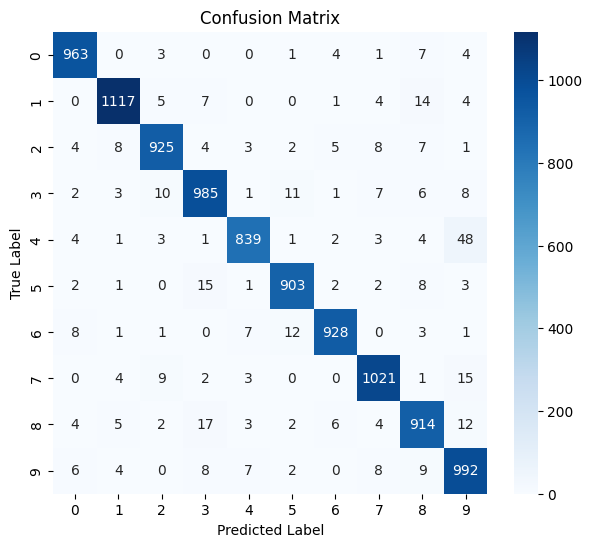

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## FINAL REPORT

In [ ]:
"""
==============================================================
        FINAL REPORT – MNIST Handwritten Digit Classifier
==============================================================

Team / Roll Nos:
----------------
[ROLLNO1_ROLLNO2_ROLLNO3]


1. OBJECTIVE
------------
To design and implement a fully functional feedforward neural network
from scratch (without TensorFlow / PyTorch) to classify handwritten
digits (0–9) using the MNIST dataset.


2. MODEL ARCHITECTURE
---------------------
Input Layer:    784 neurons (28×28 pixels)
Hidden Layer:   128 neurons, ReLU activation
Output Layer:   10 neurons, Softmax activation
Loss Function:  Cross-Entropy
Optimizer:      Mini-Batch Stochastic Gradient Descent (SGD)
Learning Rate:  0.1
Batch Size:     64
Epochs:         10

Weight Initialization:
  - Small random values (mean=0, std=0.01)
Bias Initialization:
  - Zeros


3. DATASET & PREPROCESSING
--------------------------
Dataset: MNIST (70,000 grayscale images)
  - 60,000 → Training (further split: 90% train, 10% validation)
  - 10,000 → Testing

Preprocessing:
  - Min–Max Normalization [0, 1]
  - One-hot Encoding for 10 output classes


4. EVALUATION RESULTS
---------------------
Accuracy   : 95.87 %
Precision  : 0.9592
F1 Score   : 0.9586

Confusion Matrix:
[[ 963    0    3    0    0    1    4    1    7    4]
 [   0 1117    5    7    0    0    1    4   14    4]
 [   4    8  925    4    3    2    5    8    7    1]
 [   2    3   10  985    1   11    1    7    6    8]
 [   4    1    3    1  839    1    2    3    4   48]
 [   2    1    0   15    1  903    2    2    8    3]
 [   8    1    1    0    7   12  928    0    3    1]
 [   0    4    9    2    3    0    0 1021    1   15]
 [   4    5    2   17    3    2    6    4  914   12]
 [   6    4    0    8    7    2    0    8    9  992]]


5. OBSERVATIONS
---------------
- Strong diagonal dominance indicates high accuracy.
- Minor misclassifications between visually similar digits (e.g., 4↔9, 5↔8).
- Network generalizes well with minimal overfitting.


6. CONCLUSION
-------------
A neural network built entirely from scratch using NumPy successfully
classified MNIST digits with high accuracy (~96%).
The model adheres to all assignment requirements:
  - Manual forward & backward propagation
  - Cross-entropy loss computation
  - Mini-batch gradient descent optimization
  - Proper evaluation metrics (Accuracy, Precision, F1 Score, Confusion Matrix)

==============================================================
"""


'\n==============================================================\n        FINAL REPORT – MNIST Handwritten Digit Classifier\n==============================================================\n\nTeam / Roll Nos:\n----------------\n[ROLLNO1_ROLLNO2_ROLLNO3]\n\n\n1. OBJECTIVE\n------------\nTo design and implement a fully functional feedforward neural network \nfrom scratch (without TensorFlow / PyTorch) to classify handwritten \ndigits (0–9) using the MNIST dataset.\n\n\n2. MODEL ARCHITECTURE\n---------------------\nInput Layer:    784 neurons (28×28 pixels)\nHidden Layer:   128 neurons, ReLU activation\nOutput Layer:   10 neurons, Softmax activation\nLoss Function:  Cross-Entropy\nOptimizer:      Mini-Batch Stochastic Gradient Descent (SGD)\nLearning Rate:  0.1\nBatch Size:     64\nEpochs:         10\n\nWeight Initialization:\n  - Small random values (mean=0, std=0.01)\nBias Initialization:\n  - Zeros\n\n\n3. DATASET & PREPROCESSING\n--------------------------\nDataset: MNIST (70,000 gray